# Merging Climate Datasets Exercise

Work through this notebook to practice harmonizing and merging two climate datasets that differ in temporal cadence and spatial resolution.

You will: 
- Load two public NOAA datasets directly from the cloud
- Subset to the continental US (use 230°E–300°E in longitude since the data span 0–360°)
- Use `xr.resample` to aggregate time and `xr.interp` to match grids
- Combine the variables with `xr.merge` for joint analysis

Refer back to the answer key after attempting each step.


## 2. Load the datasets

Open both remote datasets with `xr.open_dataset`, passing a reasonable chunk size for the time dimension. Assign the resulting objects to `air` and `precip`.


## 1. Setup


## 3. Subset to the continental United States and June 2020

Select the bounding box provided above and limit the time range to June 2020 for both datasets. Store the results in `air_us` and `precip_us`.
Remember that longitude runs from 0° to 360°, so select 230°E–300°E. Check whether each coordinate is ascending or descending before building the slice.


In [2]:
import matplotlib.pyplot as plt
import xarray as xr

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
except ImportError:
    ccrs = None
    cfeature = None

TEMP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.2020.nc"
PRECIP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/cpc_global_precip/precip.2020.nc"

LAT_RANGE = (20, 50)  # degrees North
LON_RANGE_360 = (230, 300)  # degrees East (equivalent to -130° to -60°)
LON_RANGE_180 = (-130, -60)  # convenience if a dataset uses -180° to 180°

TIME_RANGE = slice("2020-06-01", "2020-06-30")


In [3]:
# TODO: load the air temperature and precipitation datasets.
# Example: air = xr.open_dataset(..., chunks={"time": 8})


air = xr.open_dataset(TEMP_URL, chunks={"time": 8})
precip = xr.open_dataset(PRECIP_URL, chunks={"time": 8})


<frozen importlib._bootstrap>:488: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [4]:
# TODO: subset both datasets using `sel`, handling coordinate ordering as needed.

print(air)

air_us = air.sel(
    time=slice("2020-06-01", "2020-06-30"),
    lat=slice(50, 20),
    lon=slice(230, 300)
)

precip_us = precip.sel(
    time=slice("2020-06-01", "2020-06-30"),
    lat=slice(50, 20),
    lon=slice(230, 300)
)



<xarray.Dataset> Size: 62MB
Dimensions:  (time: 1464, lat: 73, lon: 144)
Coordinates:
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 12kB 2020-01-01 ... 2020-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 62MB dask.array<chunksize=(8, 73, 144), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimensio

## 4. Align temporal cadence

Aggregate the six-hourly air temperatures to daily means with `xr.resample`. Name the resulting DataArray `air_daily`.


In [5]:
# TODO: use xr.resample to create daily means.

air_daily = air_us['air'].resample(time='1D').mean()


## 5. Interpolate to the precipitation grid

Use `xr.interp` to interpolate the daily air temperatures onto the precipitation grid (`precip_us.lat` and `precip_us.lon`). Store the interpolated result in `air_interp`.


In [6]:
# TODO: interpolate the resampled temperature field onto the precipitation grid.

air_interp = air_daily.interp(lat=precip_us.lat,lon=precip_us.lon)
print(air_interp)

<xarray.DataArray 'air' (time: 30, lat: 60, lon: 140)> Size: 1MB
dask.array<transpose, shape=(30, 60, 140), dtype=float32, chunksize=(1, 60, 140), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 240B 2020-06-01 2020-06-02 ... 2020-06-30
  * lat      (lat) float32 240B 49.75 49.25 48.75 48.25 ... 21.25 20.75 20.25
  * lon      (lon) float32 560B 230.2 230.8 231.2 231.8 ... 298.8 299.2 299.8
Attributes: (12/13)
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    ...            ...
    parent_stat:   Other
    valid_range:   [185.16 331.16]
    dataset:       NCEP Reanalysis
    actual_range:  [188.6 324.1]
    level_desc:    0.995 sigma
    _ChunkSizes:   [  1  73 144]


## 6. Merge the datasets

Convert the aligned arrays into datasets with clear variable names and merge them with `xr.merge`. Save the output as `merged`.


In [7]:
# TODO: build datasets and merge them into one object named `merged`.

air_data = xr.Dataset({"air_temperature": air_interp})

precip_us_daily = precip_us['precip']
precip_data = xr.Dataset({"daily_precip": precip_us_daily})

merged = xr.merge([air_data, precip_data])

## 7. Inspect your result

Once your pipeline runs without `NotImplementedError`, evaluate the following cell to sanity-check the merged dataset.


In [8]:
# The assertions below should pass once you have completed the exercise.
assert set(merged.data_vars) == {"air_temperature", "daily_precip"}
assert merged.air_temperature.dims == merged.daily_precip.dims
print(merged)


<xarray.Dataset> Size: 2MB
Dimensions:          (time: 30, lat: 60, lon: 140)
Coordinates:
  * time             (time) datetime64[ns] 240B 2020-06-01 ... 2020-06-30
  * lat              (lat) float32 240B 49.75 49.25 48.75 ... 21.25 20.75 20.25
  * lon              (lon) float32 560B 230.2 230.8 231.2 ... 298.8 299.2 299.8
Data variables:
    air_temperature  (time, lat, lon) float32 1MB dask.array<chunksize=(1, 60, 140), meta=np.ndarray>
    daily_precip     (time, lat, lon) float32 1MB dask.array<chunksize=(8, 60, 140), meta=np.ndarray>


## 8. Check In

- Render both variables at the first timestep on a `cartopy` map to verify alignment visually (PlateCarree works well).
- Build a scatter plot comparing colocated temperature and precipitation values across the merged domain.
- Save the merged output with `to_netcdf` for future analysis.


In [ ]:
air_time1 = merged.air_temperature.isel(time=0)
precip_time1 = merged.daily_precip.isel(time=0)

time_merge1 = str(merged.time.values[0])[:10]

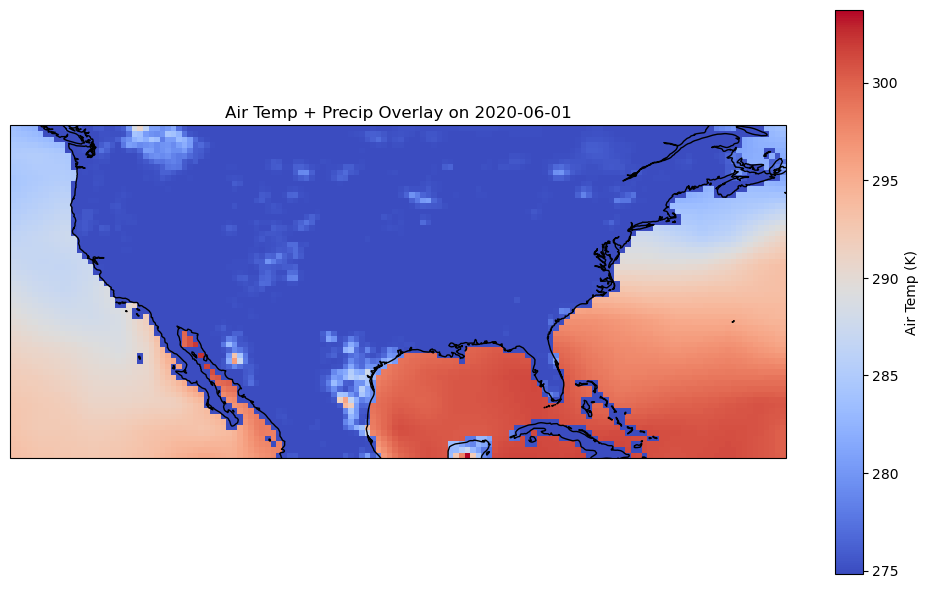

In [17]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

ax.set_extent([230, 300, 20, 50], crs=ccrs.PlateCarree())
ax.coastlines()

air_plot = ax.pcolormesh(
    air_time1.lon, air_time1.lat, air_time1,
    cmap='coolwarm',
    transform=ccrs.PlateCarree()
)
cbar_air = plt.colorbar(air_plot, ax=ax, orientation='vertical', label='Air Temp (K)')

precip_plot = ax.pcolormesh(
    precip_time1.lon, precip_time1.lat, precip_time1,
    cmap='coolwarm',
    transform=ccrs.PlateCarree()
)

ax.set_title(f"Air Temp + Precip Overlay on {time_merge1}")

plt.tight_layout()
plt.show()


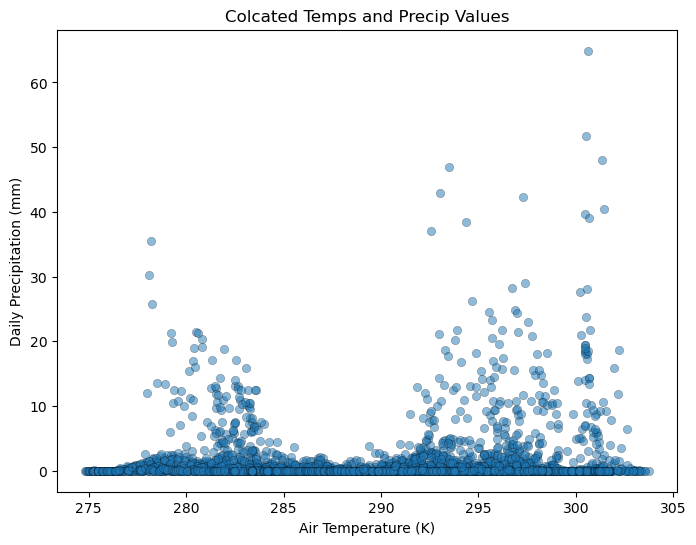

In [15]:
import matplotlib.pyplot as plt

air_values = air_time1.values.flatten()
precip_values = precip_time1.values.flatten()

plt.figure(figsize=(8, 6))
plt.scatter(air_valuess, precip_values, alpha=0.5, edgecolor='k', linewidth=0.3)
plt.xlabel("Air Temperature (K)")
plt.ylabel("Daily Precipitation (mm)")
plt.title(f"Colcated Temps and Precip Values")
plt.show()
